In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys, os, time, random
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import sys
from pathlib import Path
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
#%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

from glob import glob
from tifffile import imread
from csbdeep.utils import Path, normalize
from csbdeep.io import save_tiff_imagej_compatible

from stardist import random_label_cmap
from stardist.models import StarDist3D
from tqdm import tqdm

np.random.seed(1)
lbl_cmap = random_label_cmap()



2025-07-15 15:07:45.425146: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-15 15:07:45.453523: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-15 15:07:45.453563: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-15 15:07:45.454432: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-15 15:07:45.460978: I tensorflow/core/platform/cpu_feature_guar

In [17]:
from stardist.models import Config3D
X = sorted(glob('/storage01/miroslavm/3d_segmentation_models/Stardist/processed_w_stardist/val/images/*.tif'))
#X = sorted(glob('/NAS/mmaiurov/Datasets/Hela_MRC_stardist/val/images/*.tif'))
X = list(map(imread,X))
#Y = sorted(glob('/NAS/mmaiurov/Datasets/Hela_MRC_stardist/val/masks/*.tif'))
Y = sorted(glob('/storage01/miroslavm/3d_segmentation_models/Stardist/processed_w_stardist/val/masks/*.tif'))

#n_channel = 1 if X[0].ndim == 3 else X[0].shape[-1]
axis_norm = (0,1,2)   # normalize channels independently
# axis_norm = (0,1,2,3) # normalize channels jointly
#if n_channel > 1:
#    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
# n_rays = 128
# n_channel = 1
# use_gpu = False and gputools_available()
# grid = tuple(1 if a > 1.5 else 4 for a in anisotropy)

# conf = Config3D (
#             rays             = rays,
#             grid             = grid,
#             anisotropy       = anisotropy,
#             use_gpu          = use_gpu,
#             n_channel_in     = n_channel,
#             # adjust for your data below (make patch size as large as possible)
#             train_patch_size = (12,96,96),
#             train_batch_size = 4,
            
#         )    

#model = StarDist3D(None, name='stardist_hela', basedir='models')
model = StarDist3D(None, name='stardist_final', basedir='models')
axes = 'ZYX'                    # or 'ZYXC' if your data has a channel axis
length = len(X)



Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.497795, nms_thresh=0.3.


In [3]:
# for i in tqdm(range(length)):
#     img = normalize(X[i].astype(np.float32), 1,99.8, axis=axis_norm)
#     # labels, details = model.predict_instances(img)
#     labels, details = model.predict_instances(img,
#                                           axes=axes,
#                                           n_tiles=model._guess_n_tiles(img))
    
#     origfilename = Path(Y[i]).stem
    
#     maskfilename = pred_dir + origfilename + '.tif'
#     # save_tiff_imagej_compatible('nagy.tif', img, axes='ZYX')
#     save_tiff_imagej_compatible(maskfilename, labels, axes='ZYX')

In [4]:

# img = normalize(X[0].astype(np.float32), 1,99.8, axis=axis_norm)
#     # labels, details = model.predict_instances(img)
# labels, details = model.predict_instances(img,
#                                           axes=axes,
#                                           n_tiles=model._guess_n_tiles(img))
    
# origfilename = Path(Y[0]).stem
    
# maskfilename =  origfilename + '.tif'
#     # save_tiff_imagej_compatible('nagy.tif', img, axes='ZYX')
# save_tiff_imagej_compatible(maskfilename, labels, axes='ZYX')

In [5]:
from stardist.matching import matching
import numpy as np
f1=[]
prec=[]
rec=[]
n_t=[]
n_p=[]

for i in range(len(X)):
    img = normalize(X[i].astype(np.float32), 1, 99.8, axis=axis_norm)
    labels_pred, _ = model.predict_instances(img, axes='ZYX', n_tiles=model._guess_n_tiles(img))
    labels_true = imread(Y[i])

    stats = matching(labels_true, labels_pred, thresh=0.497795)
    
    f1.append(stats.f1)
    prec.append(stats.precision)
    rec.append(stats.recall)
    n_t.append(stats.n_true)
    n_p.append(stats.n_pred)
    print(f"Image {i}:")
    print(f"  F1 score:     {stats.f1:.4f}")
    print(f"  Precision:    {stats.precision:.4f}")
    print(f"  Recall:       {stats.recall:.4f}")
    print(f"  GT objects:   {stats.n_true}")
    print(f"  Pred objects: {stats.n_pred}")


2025-07-15 14:56:11.225134: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
100%|███████████████████████████████████████████████████████████████| 48/48 [00:09<00:00,  4.82it/s]


Image 0:
  F1 score:     0.7297
  Precision:    0.7751
  Recall:       0.6894
  GT objects:   470
  Pred objects: 418


In [6]:
mean_f1   = np.mean(f1)
mean_prec = np.mean(prec)
mean_rec  = np.mean(rec)
mean_gt   = np.mean(n_t)
mean_pred = np.mean(n_p)
print("\n===== Mean metrics across dataset =====")
print(f"Mean F1 score:     {mean_f1:.4f}")
print(f"Mean Precision:    {mean_prec:.4f}")
print(f"Mean Recall:       {mean_rec:.4f}")
print(f"Mean GT objects:   {mean_gt:.1f}")
print(f"Mean Pred objects: {mean_pred:.1f}")


===== Mean metrics across dataset =====
Mean F1 score:     0.7297
Mean Precision:    0.7751
Mean Recall:       0.6894
Mean GT objects:   470.0
Mean Pred objects: 418.0


100%|███████████████████████████████████████████████████████████████| 48/48 [00:04<00:00, 10.64it/s]


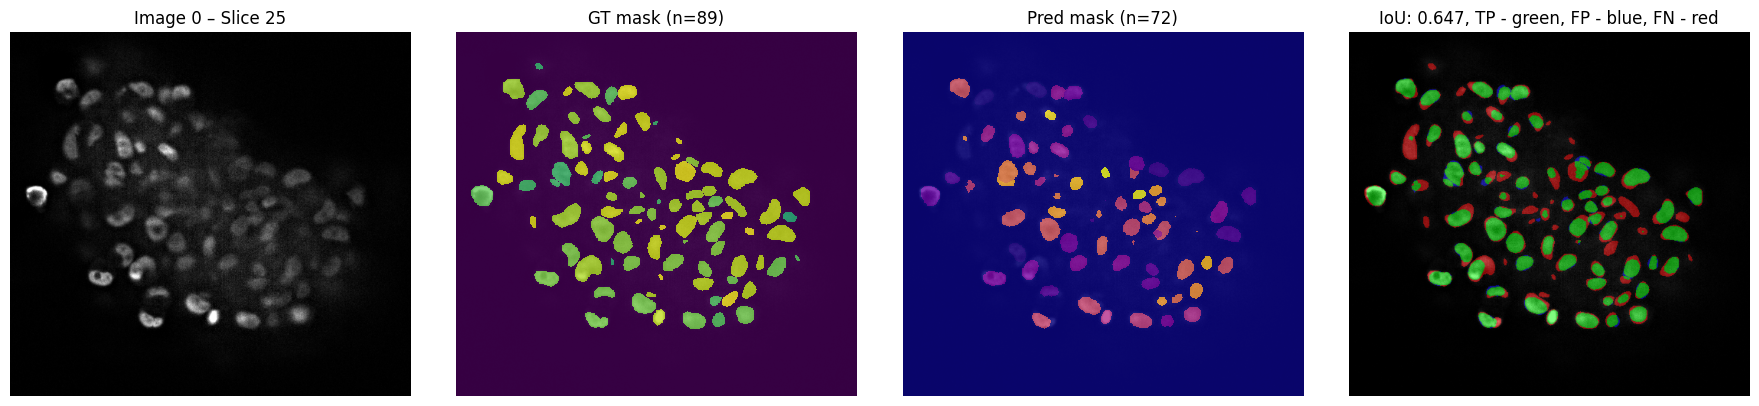

In [7]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tifffile import imread
from matplotlib.colors import ListedColormap

def compute_iou(gt, pred):
    intersection = np.logical_and(gt > 0, pred > 0).sum()
    union = np.logical_or(gt > 0, pred > 0).sum()
    return intersection / union if union > 0 else 0.0

def create_tp_fp_fn_map(gt, pred):
    tp = np.logical_and(gt > 0, pred > 0)
    fn = np.logical_and(gt > 0, pred == 0)
    fp = np.logical_and(gt == 0, pred > 0)
    
    overlay = np.zeros((*gt.shape, 3), dtype=np.float32)
    overlay[tp] = [0, 1, 0]   # green (TP)
    overlay[fn] = [1, 0, 0]   # red   (FN)
    overlay[fp] = [0, 0, 1]   # blue  (FP)
    return overlay

# 4 случайных изображения
rand_idx = random.sample(range(len(X)), 1)
fig, axes = plt.subplots(len(rand_idx), 4, figsize=(18, 4 * len(rand_idx)))
axes = np.array(axes).reshape(len(rand_idx), 4)
iou_scores = []

for row, idx in enumerate(rand_idx):
    img_norm = normalize(X[idx].astype(np.float32), 1, 99.8, axis=axis_norm)
    labels_pred, _ = model.predict_instances(img_norm, axes='ZYX', n_tiles=model._guess_n_tiles(img_norm))
    labels_true = imread(Y[idx])

    z = img_norm.shape[0] // 2
    img_slice = img_norm[z]
    gt_slice = labels_true[z]
    pred_slice = labels_pred[z]
    n_gt   = len(np.unique(gt_slice))   - (1 if 0 in gt_slice  else 0)
    n_pred = len(np.unique(pred_slice)) - (1 if 0 in pred_slice else 0)
    iou = compute_iou(gt_slice, pred_slice)
    iou_scores.append(iou)

    # (1) оригинал
    ax = axes[row, 0]
    ax.imshow(img_slice, cmap='gray')
    ax.set_title(f"Image {idx} – Slice {z}")
    ax.axis('off')

    # (2) GT
    ax = axes[row, 1]
    ax.imshow(img_slice, cmap='gray')
    ax.imshow(gt_slice, cmap='viridis', alpha=0.8, interpolation='none')
    ax.set_title(f"GT mask (n={n_gt})")
    ax.axis('off')

    # (3) Prediction
    ax = axes[row, 2]
    ax.imshow(img_slice, cmap='gray')
    ax.imshow(pred_slice, cmap='plasma', alpha=0.8, interpolation='none')
    ax.set_title(f"Pred mask (n={n_pred})")
    ax.axis('off')

    # (4) Overlay: TP (green), FN (red), FP (blue)
    overlay = create_tp_fp_fn_map(gt_slice, pred_slice)
    ax = axes[row, 3]
    ax.imshow(img_slice, cmap='gray')
    ax.imshow(overlay, alpha=0.5)
    ax.set_title(f"IoU: {iou:.3f}, TP - green, FP - blue, FN - red")
    ax.axis('off')

plt.tight_layout()
plt.show()


In [8]:
def compute_slice_iou_mean(X, Y, model, axis_norm):
    all_iou = []
    for i in range(len(X)):
        img = normalize(X[i].astype(np.float32), 1, 99.8, axis=axis_norm)
        labels_pred, _ = model.predict_instances(img, axes='ZYX', n_tiles=model._guess_n_tiles(img))
        labels_true = imread(Y[i])
        z = img.shape[0] // 2
        iou = compute_iou(labels_true[z], labels_pred[z])
        all_iou.append(iou)
    return np.mean(all_iou)

mean_iou = compute_slice_iou_mean(X, Y, model, axis_norm)
print(f"\n==== Mean 2D IoU on central slice across dataset: {mean_iou:.4f}")


100%|███████████████████████████████████████████████████████████████| 48/48 [00:04<00:00, 10.67it/s]



==== Mean 2D IoU on central slice across dataset: 0.6471


In [9]:
def mean_iou_whole_volume(X, Y, model, axis_norm):
    inter_total, union_total = 0, 0
    for i in range(len(X)):
        img = normalize(X[i].astype(np.float32), 1, 99.8, axis=axis_norm)
        pred, _ = model.predict_instances(img, axes='ZYX',
                                          n_tiles=model._guess_n_tiles(img))
        gt = imread(Y[i])

        inter_total += np.logical_and(gt > 0, pred > 0).sum()
        union_total += np.logical_or(gt > 0, pred > 0).sum()

    return inter_total / union_total if union_total else 0.0

mean_iou_3d = mean_iou_whole_volume(X, Y, model, axis_norm)
print(f"Global 3D IoU across dataset: {mean_iou_3d:.4f}")

100%|███████████████████████████████████████████████████████████████| 48/48 [00:04<00:00, 10.63it/s]


Global 3D IoU across dataset: 0.6273


In [10]:
def compute_dice(gt, pred):
    intersection = np.logical_and(gt > 0, pred > 0).sum()
    volume_sum = (gt > 0).sum() + (pred > 0).sum()
    return (2 * intersection) / volume_sum if volume_sum else 1.0

def mean_dice_whole_volume(X, Y, model, axis_norm):
    dice_scores = []
    for i in range(len(X)):
        img = normalize(X[i].astype(np.float32), 1, 99.8, axis=axis_norm)
        pred, _ = model.predict_instances(img, axes='ZYX',
                                          n_tiles=model._guess_n_tiles(img))
        gt = imread(Y[i])
        dice = compute_dice(gt, pred)
        dice_scores.append(dice)
    return np.mean(dice_scores)
mean_dice_3d = mean_dice_whole_volume(X, Y, model, axis_norm)
print(f"Global 3D Dice across dataset: {mean_dice_3d:.4f}")

100%|███████████████████████████████████████████████████████████████| 48/48 [00:04<00:00, 10.63it/s]


Global 3D Dice across dataset: 0.7709


In [18]:
def compute_metrics_fast(gt, pred):
    from scipy.sparse import coo_matrix

    gt = gt.astype(np.int32)
    pred = pred.astype(np.int32)

    # --- Pixelwise Dice ---
    intersection = np.logical_and(gt > 0, pred > 0).sum()
    volume_sum = (gt > 0).sum() + (pred > 0).sum()
    dice_pixelwise = (2 * intersection) / volume_sum if volume_sum else 1.0

    # --- Instance Dice ---
    gt_flat = gt.ravel()
    pred_flat = pred.ravel()

    max_gt = gt_flat.max()
    max_pred = pred_flat.max()

    overlap = coo_matrix(
        (np.ones_like(gt_flat), (gt_flat, pred_flat)),
        shape=(max_gt + 1, max_pred + 1)
    ).toarray()

    # Remove background
    overlap = overlap[1:, 1:]  # shape: (n_gt, n_pred)
    if overlap.size == 0:
        dice_instance = 0.0
    else:
        gt_sizes = overlap.sum(axis=1, keepdims=True)  # shape (n_gt, 1)
        pred_sizes = overlap.sum(axis=0, keepdims=True)  # shape (1, n_pred)

        union = gt_sizes + pred_sizes - overlap
        union[union <= 0] = 1  # prevent div-by-zero or negative union

        dice_matrix = 2 * overlap / union
        dice_matrix = np.clip(dice_matrix, 0.0, 1.0)  # hard clamp to [0,1]
        dice_instance = dice_matrix.max(axis=1).mean()

    # --- Precision / Recall ---
    tp = (gt > 0) & (pred > 0)
    fp = (gt == 0) & (pred > 0)
    fn = (gt > 0) & (pred == 0)

    tp_sum = tp.sum()
    fp_sum = fp.sum()
    fn_sum = fn.sum()

    precision = tp_sum / (tp_sum + fp_sum) if (tp_sum + fp_sum) else 0.0
    recall    = tp_sum / (tp_sum + fn_sum) if (tp_sum + fn_sum) else 0.0

    return {
        "dice_pixelwise": dice_pixelwise,
        "dice_instance": dice_instance,
        "precision": precision,
        "recall": recall
    }

In [19]:
def evaluate_dataset(X, Y, model, axis_norm):
    all_metrics = {
        "dice_pixelwise": [],
        "dice_instance": [],
        "precision": [],
        "recall": []
    }

    for i in range(len(X)):
        print(f"[INFO] Processing volume {i + 1}/{len(X)}")

        img = normalize(X[i].astype(np.float32), 1, 99.8, axis=axis_norm)
        pred, _ = model.predict_instances(img, axes='ZYX', n_tiles=(2,2,2))  # вручную задать тайлы
        gt = imread(Y[i])

        metrics = compute_metrics_fast(gt, pred)
        for key in all_metrics:
            all_metrics[key].append(metrics[key])

    return {k: np.mean(v) for k, v in all_metrics.items()}

In [20]:
results = evaluate_dataset(X, Y, model, axis_norm)
print(f"Pixelwise Dice:  {results['dice_pixelwise']:.4f}")
print(f"Instance Dice:   {results['dice_instance']:.4f}")
print(f"Precision:        {results['precision']:.4f}")
print(f"Recall:           {results['recall']:.4f}")

[INFO] Processing volume 1/1


100%|█████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.73s/it]


Pixelwise Dice:  0.5346
Instance Dice:   0.5915
Precision:        0.6424
Recall:           0.4578
